In [2]:
from utils import *
from DataGenerator import *
from Models_normal import *
import torch.optim as optim
from Analysis import fixed_model_batch_analysis
from DataLoader import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor

np.random.seed = 55
torch.random.seed = 55


In [3]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

state_dict = torch.load('../running_scripts/all_results/sept_result_mnist/mnist_training/try_num0/epoch_60/model.pth', weights_only=False)
model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


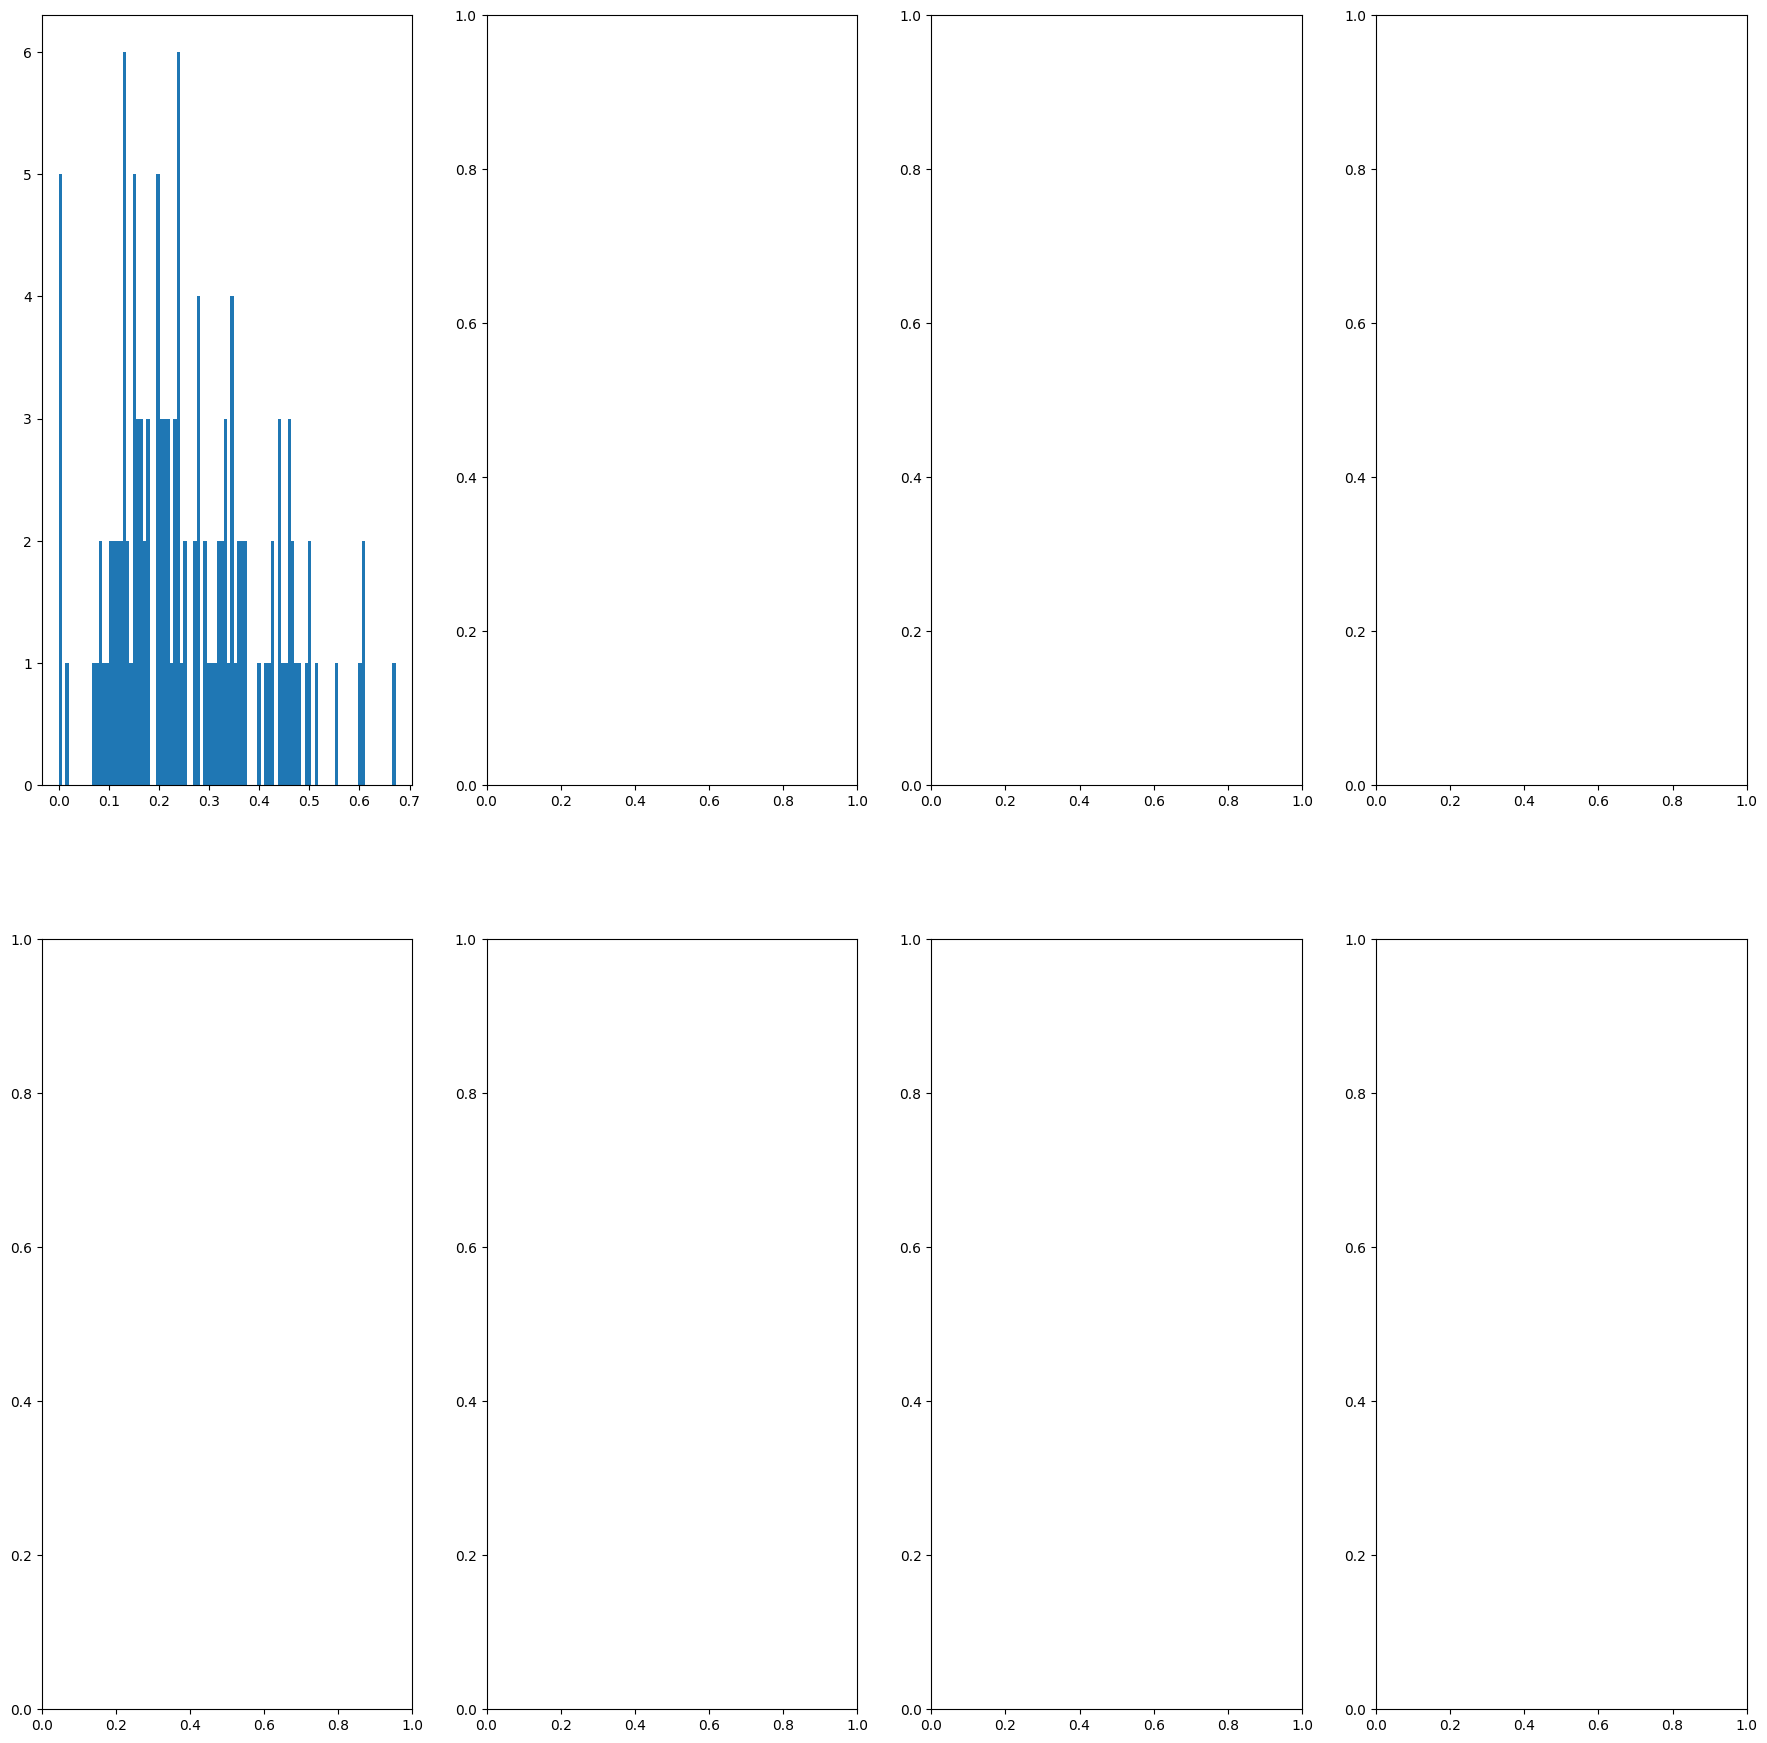

---


In [4]:
anal_path = '../spike_analysis/spike_resume/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, train_samples, train_labels, device, '{}_{}'.format(anal_path, 'train_'), 'analyze')
plt.close()
print("---")

In [5]:
def spike_detection_nd(points, max_hyperplanes=7, min_points_for_hyperplane=100, residual_threshold=0.5, merge_threshold=0.01):
    residual_threshold *= (points.shape[1] - 1)
    # merge_threshold *= (points.shape[1])
    def fit_hyperplane_ransac(points):
        n_dims = points.shape[1]
        dependent_dim = np.random.randint(n_dims)
        
        X = np.delete(points, dependent_dim, axis=1)
        y = points[:, dependent_dim]
        
        ransac = RANSACRegressor(LinearRegression(), 
                                 max_trials=1000, 
                                 min_samples=n_dims,
                                 residual_threshold=residual_threshold,
                                 stop_probability=0.99)
        ransac.fit(X, y)
        return ransac, dependent_dim

    def get_hyperplane_eq(ransac, dependent_dim, n_dims):
        coef = ransac.estimator_.coef_
        intercept = ransac.estimator_.intercept_
        
        full_coef = np.zeros(n_dims)
        full_coef[:dependent_dim] = coef[:dependent_dim]
        full_coef[dependent_dim+1:] = coef[dependent_dim:]
        full_coef[dependent_dim] = -1
        
        return full_coef, intercept

    def point_to_hyperplane_distance(point, coef, intercept):
        return np.abs(np.dot(coef, point) + intercept) / np.linalg.norm(coef)

    def hyperplane_distance(coef1, intercept1, coef2, intercept2):
        # Calculate the angle between the normal vectors of the hyperplanes
        cos_angle = np.dot(coef1, coef2) / (np.linalg.norm(coef1) * np.linalg.norm(coef2))
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        
        # Calculate the distance between the hyperplanes at the origin
        d = np.abs(intercept1 - intercept2) / np.linalg.norm(coef1)
        
        return angle, d

    n_dims = points.shape[1]
    hyperplanes = []
    remaining_points = points.copy()
    assigned_points = []
    total_error = 0

    for _ in range(max_hyperplanes):
        if len(remaining_points) < min_points_for_hyperplane:
            break
        
        ransac, dependent_dim = fit_hyperplane_ransac(remaining_points)
        coef, intercept = get_hyperplane_eq(ransac, dependent_dim, n_dims)
        
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]
        
        hyperplane_error = sum(point_to_hyperplane_distance(p, coef, intercept) for p in inlier_points)
        total_error += hyperplane_error
        
        hyperplanes.append((coef, intercept, len(inlier_points), hyperplane_error))
        assigned_points.append(inlier_points)
        
        remaining_points = remaining_points[~inlier_mask]

    # Assign remaining points to the nearest hyperplane
    for point in remaining_points:
        distances = [point_to_hyperplane_distance(point, coef, intercept) for coef, intercept, _, _ in hyperplanes]
        nearest_hyperplane_index = np.argmin(distances)
        total_error += distances[nearest_hyperplane_index]
        assigned_points[nearest_hyperplane_index] = np.vstack([assigned_points[nearest_hyperplane_index], point])

    # Merge close hyperplanes
    i = 0
    while i < len(hyperplanes):
        j = i + 1
        while j < len(hyperplanes):
            angle, dist = hyperplane_distance(hyperplanes[i][0], hyperplanes[i][1], hyperplanes[j][0], hyperplanes[j][1])
            # if angle < merge_threshold and dist < merge_threshold:
            if angle < merge_threshold:
                # Merge hyperplanes
                new_coef = (hyperplanes[i][0] + hyperplanes[j][0]) / 2
                new_intercept = (hyperplanes[i][1] + hyperplanes[j][1]) / 2
                new_inliers = hyperplanes[i][2] + hyperplanes[j][2]
                new_error = hyperplanes[i][3] + hyperplanes[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])
                
                hyperplanes[i] = (new_coef, new_intercept, new_inliers, new_error)
                assigned_points[i] = new_points
                
                # Remove the merged hyperplane
                del hyperplanes[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # Sort hyperplanes by number of inliers (descending)
    hyperplanes = sorted(zip(hyperplanes, assigned_points), key=lambda x: x[0][2], reverse=True)
    hyperplanes, assigned_points = zip(*hyperplanes)

    return hyperplanes, total_error, assigned_points


def assign_points_to_hyperplanes(points, hyperplanes):
        """
        Efficiently assign points to the closest hyperplane and calculate the error.

        Parameters:
        points: numpy array of shape (n_points, n_dimensions)
        hyperplanes: list of tuples (coef, intercept), where coef is a numpy array

        Returns:
        assignments: numpy array of shape (n_points,) containing hyperplane indices
        total_error: float, sum of distances from points to their assigned hyperplanes
        hyperplane_errors: list of errors for each hyperplane
        """
        n_points, n_dims = points.shape
        n_hyperplanes = len(hyperplanes)

        # Prepare hyperplane coefficients and intercepts
        coefs = torch.Tensor([h[0] for h in hyperplanes]).to(points.device)
        intercepts = torch.Tensor([h[1] for h in hyperplanes]).to(points.device)

        # Calculate distances from each point to each hyperplane
        # Using broadcasting to avoid explicit loops
        distances = torch.abs(torch.matmul(points, coefs.T) + intercepts) / torch.linalg.norm(coefs, dim=1)

        # Find the closest hyperplane for each point
        assignments = torch.argmin(distances, dim=1)

        # Calculate the total error
        total_error = torch.sum(torch.min(distances, dim=1)[0])

        # Calculate error for each hyperplane
        hyperplane_errors = [torch.sum(distances[assignments == i, i]) for i in range(n_hyperplanes)]

        return assignments, total_error, hyperplane_errors


In [6]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__)) ## previous version 3.2.1

matplotlib: 3.7.0


In [7]:
# # creating 3d plot using matplotlib 
# # in python 

# # for creating a responsive plot 
# %matplotlib widget 

# from mpl_toolkits.mplot3d import Axes3D 


# # creating figure 
# fig = plt.figure() 
# ax = Axes3D(fig) 
  
# # creating the plot
# ax = fig.add_subplot(111, projection='3d') 
# plot_geeks = ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='green') 
  
# # setting title and labels 
# ax.set_title("3D plot") 
# ax.set_xlabel('x-axis') 
# ax.set_ylabel('y-axis') 
# ax.set_zlabel('z-axis') 
  
# # displaying the plot 
# plt.show() 

# # fig = plt.figure(figsize=(12, 8))
# # ax = fig.add_subplot(111, projection='3d')
# # ax.view_init(elev=15, azim=60, roll=10)

# # plt.show()

Hyperplane 1: -0.0300x1 + -0.1617x2 + -1.0000x3 + 0.1326 = 0 (3647 points)
Hyperplane 2: -1.0000x1 + -3.6683x2 + 0.5399x3 + -0.2566 = 0 (978 points)
Hyperplane 3: 0.1816x1 + -1.0000x2 + -1.6571x3 + -2.0589 = 0 (203 points)
Hyperplane 4: 0.0171x1 + -1.0000x2 + -3.5465x3 + 1.5974 = 0 (61 points)


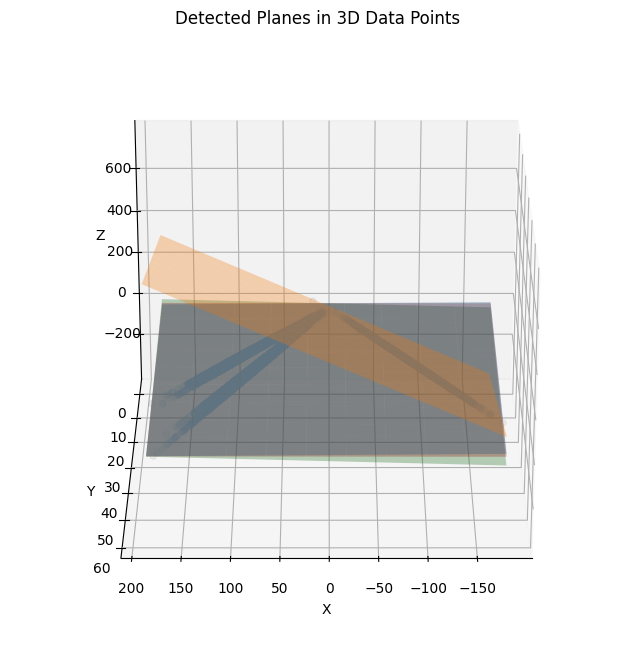

In [8]:
idx_layer = 10

mnist_pca = np.array(results_dict['pca_3'][idx_layer]).transpose()

class_idx = 0

# data = results_dict['pca_3'][11].detach().cpu().numpy()


mnist_labels = train_labels.detach().cpu().numpy()
mnist_data = train_samples.detach().cpu().numpy().reshape(train_samples.shape[0], 28 * 28)

class_data_indices = np.where(mnist_labels == class_idx)[0]
class_data = mnist_pca[class_data_indices]

points = class_data.copy()

detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='gray', alpha=0.1, label='Data Points')
xx, yy = np.meshgrid(np.linspace(points[:, 0].min(), points[:, 0].max(), 10),
                        np.linspace(points[:, 1].min(), points[:, 1].max(), 10))
for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
    zz = (-coef[0] * xx - coef[1] * yy - intercept) / coef[2]
    ax.plot_surface(xx, yy, zz, alpha=0.3, label=f'Plane {i+1}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Detected Planes in 3D Data Points')
ax.view_init(elev=25, azim=90, roll=0)

# Print hyperplane equations and number of inliers
for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
    eq = " + ".join([f"{c:.4f}x{j+1}" for j, c in enumerate(coef)])
    print(f"Hyperplane {i+1}: {eq} + {intercept:.4f} = 0 ({num_inliers} points)")
plt.show()


In [9]:
#     viewing_angles = [
#     # Class 0
#     [
#         # Spike angles for Class 0
#         [(35, 25, 0), (40, 30, 0), (30, 20, 0), (45, 15, 0), (25, 10, 0)]
#     ],
#     # Class 1
#     [
#         # Spike angles for Class 1
#         [(40, 25, 0), (30, 35, 0), (35, 40, 0), (25, 20, 0), (30, 15, 0),
#          (45, 30, 0), (35, 20, 0), (40, 10, 0), (30, 45, 0)]
#     ],
#     # Class 2
#     [
#         # Spike angles for Class 2
#         [(25, 30, 0), (30, 25, 0)]
#     ],
#     # Class 3
#     [
#         # Spike angles for Class 3
#         [(40, 20, 0), (35, 30, 0), (30, 40, 0), (25, 35, 0), (30, 20, 0)]
#     ],
#     # Class 4
#     [
#         # Layer 0
#         [(25, 30, 0), (30, 20, 0), (35, 45, 0)],
#         # Layer 1
#         [(27, 32, 0), (32, 22, 0), (37, 47, 0)],
#         # Layer 2
#         [(29, 34, 0), (34, 24, 0), (39, 49, 0)]
#     ],
#     # Class 5
#     [
#         # Layer 0
#         [(40, 20, 0), (30, 35, 0), (25, 15, 0)],
#         # Layer 1
#         [(42, 22, 0), (32, 37, 0), (27, 17, 0)],
#         # Layer 2
#         [(44, 24, 0), (34, 39, 0), (29, 19, 0)]
#     ],
#     # Class 6
#     [
#         # Layer 0
#         [(30, 25, 0), (35, 30, 0), (20, 40, 0)],
#         # Layer 1
#         [(32, 27, 0), (37, 32, 0), (22, 42, 0)],
#         # Layer 2
#         [(34, 29, 0), (39, 34, 0), (24, 44, 0)]
#     ],
#     # Class 7
#     [
#         # Layer 0
#         [(25, 20, 0), (40, 50, 0), (30, 35, 0)],
#         # Layer 1
#         [(27, 22, 0), (42, 52, 0), (32, 37, 0)],
#         # Layer 2
#         [(29, 24, 0), (44, 54, 0), (34, 39, 0)]
#     ],
#     # Class 8
#     [
#         # Layer 0
#         [(35, 20, 0), (30, 45, 0), (25, 15, 0)],
#         # Layer 1
#         [(37, 22, 0), (32, 47, 0), (27, 17, 0)],
#         # Layer 2
#         [(39, 24, 0), (34, 49, 0), (29, 19, 0)]
#     ],
#     # Class 9
#     [
#         # Layer 0
#         [(40, 25, 0), (30, 15, 0), (35, 30, 0)],
#         # Layer 1
#         [(42, 27, 0), (32, 17, 0), (37, 32, 0)],
#         # Layer 2
#         [(44, 29, 0), (34, 19, 0), (39, 34, 0)]
#     ]
# ]

viewing_angles = [
    # Class 0
    [
        # Layer 0
        [(30, 20, 0), (25, 45, 0), (35, 15, 0)],
        # Layer 1
        [(32, 22, 0), (27, 47, 0), (37, 17, 0)],
        # Layer 2
        [(34, 24, 0), (29, 49, 0), (39, 19, 0)],
        # Layer 3
        [(28, 30, 0), (26, 40, 0), (36, 20, 0)],
        # Layer 4
        [(25, 35, 0), (30, 25, 0), (38, 18, 0)],
        # Layer 5
        [(33, 28, 0), (31, 42, 0), (34, 22, 0)],
        # Layer 6
        [(35, 30, 0), (32, 45, 0), (37, 23, 0)],
        # Layer 7
        [(29, 32, 0), (30, 38, 0), (39, 24, 0)],
        # Layer 8
        [(27, 40, 0), (34, 20, 0), (35, 30, 0)],
        # Layer 9
        [(31, 25, 0), (33, 35, 0), (38, 21, 0)],
        # Layer 10
        [(36, 28, 0), (28, 44, 0), (32, 27, 0)],
        # Layer 11
        [(37, 29, 0), (31, 46, 0), (33, 25, 0)]
    ],
    # Class 1
    [
        # Layer 0
        [(40, 10, 0), (20, 35, 0), (30, 50, 0)],
        # Layer 1
        [(42, 12, 0), (22, 37, 0), (32, 52, 0)],
        # Layer 2
        [(44, 14, 0), (24, 39, 0), (34, 54, 0)],
        # Layer 3
        [(38, 18, 0), (26, 41, 0), (36, 56, 0)],
        # Layer 4
        [(39, 20, 0), (28, 33, 0), (31, 58, 0)],
        # Layer 5
        [(41, 15, 0), (25, 38, 0), (33, 55, 0)],
        # Layer 6
        [(43, 17, 0), (29, 36, 0), (35, 57, 0)],
        # Layer 7
        [(37, 19, 0), (30, 34, 0), (32, 53, 0)],
        # Layer 8
        [(34, 23, 0), (31, 31, 0), (30, 51, 0)],
        # Layer 9
        [(45, 11, 0), (27, 29, 0), (28, 49, 0)],
        # Layer 10
        [(46, 13, 0), (23, 43, 0), (26, 48, 0)],
        # Layer 11
        [(47, 15, 0), (25, 45, 0), (29, 50, 0)]
    ],
    # Class 2
    [
        # Layer 0
        [(25, 25, 0), (30, 60, 0), (35, 30, 0)],
        # Layer 1
        [(27, 27, 0), (32, 62, 0), (37, 32, 0)],
        # Layer 2
        [(29, 29, 0), (34, 64, 0), (39, 34, 0)],
        # Layer 3
        [(28, 33, 0), (33, 58, 0), (38, 31, 0)],
        # Layer 4
        [(26, 31, 0), (35, 61, 0), (36, 33, 0)],
        # Layer 5
        [(30, 28, 0), (31, 59, 0), (40, 35, 0)],
        # Layer 6
        [(32, 30, 0), (36, 57, 0), (41, 37, 0)],
        # Layer 7
        [(33, 32, 0), (29, 63, 0), (37, 36, 0)],
        # Layer 8
        [(31, 26, 0), (28, 65, 0), (34, 38, 0)],
        # Layer 9
        [(27, 34, 0), (39, 56, 0), (42, 40, 0)],
        # Layer 10
        [(28, 29, 0), (40, 55, 0), (43, 41, 0)],
        # Layer 11
        [(30, 31, 0), (38, 58, 0), (41, 39, 0)]
    ],
    # Class 3
    [
        # Layer 0
        [(35, 15, 0), (30, 40, 0), (40, 10, 0)],
        # Layer 1
        [(37, 17, 0), (32, 42, 0), (42, 12, 0)],
        # Layer 2
        [(39, 19, 0), (34, 44, 0), (44, 14, 0)],
        # Layer 3
        [(38, 16, 0), (31, 41, 0), (43, 13, 0)],
        # Layer 4
        [(36, 18, 0), (33, 39, 0), (41, 11, 0)],
        # Layer 5
        [(40, 20, 0), (29, 38, 0), (37, 15, 0)],
        # Layer 6
        [(41, 21, 0), (35, 43, 0), (38, 18, 0)],
        # Layer 7
        [(42, 22, 0), (30, 45, 0), (39, 16, 0)],
        # Layer 8
        [(33, 25, 0), (34, 48, 0), (36, 17, 0)],
        # Layer 9
        [(38, 28, 0), (32, 47, 0), (40, 19, 0)],
        # Layer 10
        [(37, 24, 0), (31, 46, 0), (35, 13, 0)],
        # Layer 11
        [(39, 26, 0), (36, 49, 0), (34, 14, 0)]
    ],
    # Class 4
    [
        # Layer 0
        [(25, 30, 0), (30, 20, 0), (35, 45, 0)],
        # Layer 1
        [(27, 32, 0), (32, 22, 0), (37, 47, 0)],
        # Layer 2
        [(29, 34, 0), (34, 24, 0), (39, 49, 0)],
        # Layer 3
        [(28, 36, 0), (31, 23, 0), (38, 46, 0)],
        # Layer 4
        [(26, 31, 0), (33, 25, 0), (36, 44, 0)],
        # Layer 5
        [(30, 28, 0), (35, 26, 0), (32, 48, 0)],
        # Layer 6
        [(31, 29, 0), (37, 30, 0), (33, 42, 0)],
        # Layer 7
        [(32, 33, 0), (29, 34, 0), (34, 40, 0)],
        # Layer 8
        [(33, 35, 0), (30, 32, 0), (36, 43, 0)],
        # Layer 9
        [(34, 37, 0), (28, 36, 0), (31, 41, 0)],
        # Layer 10
        [(35, 38, 0), (26, 39, 0), (29, 47, 0)],
        # Layer 11
        [(36, 40, 0), (27, 42, 0), (30, 44, 0)]
    ],
    # Class 5
    [
        # Layer 0
        [(40, 20, 0), (30, 35, 0), (25, 15, 0)],
        # Layer 1
        [(42, 22, 0), (32, 37, 0), (27, 17, 0)],
        # Layer 2
        [(44, 24, 0), (34, 39, 0), (29, 19, 0)],
        # Layer 3
        [(45, 25, 0), (36, 40, 0), (28, 18, 0)],
        # Layer 4
        [(41, 21, 0), (33, 38, 0), (26, 16, 0)],
        # Layer 5
        [(39, 23, 0), (35, 41, 0), (30, 20, 0)],
        # Layer 6
        [(38, 27, 0), (32, 43, 0), (31, 22, 0)],
        # Layer 7
        [(37, 24, 0), (31, 42, 0), (33, 19, 0)],
        # Layer 8
        [(36, 26, 0), (29, 44, 0), (34, 21, 0)],
        # Layer 9
        [(35, 29, 0), (28, 46, 0), (32, 23, 0)],
        # Layer 10
        [(39, 31, 0), (30, 45, 0), (27, 18, 0)],
        # Layer 11
        [(40, 33, 0), (34, 47, 0), (29, 25, 0)]
    ],
    # Class 6
    [
        # Layer 0
        [(30, 25, 0), (35, 30, 0), (20, 40, 0)],
        # Layer 1
        [(32, 27, 0), (37, 32, 0), (22, 42, 0)],
        # Layer 2
        [(34, 29, 0), (39, 34, 0), (24, 44, 0)],
        # Layer 3
        [(33, 28, 0), (38, 31, 0), (23, 43, 0)],
        # Layer 4
        [(36, 30, 0), (35, 33, 0), (25, 41, 0)],
        # Layer 5
        [(31, 26, 0), (32, 36, 0), (27, 39, 0)],
        # Layer 6
        [(29, 24, 0), (34, 35, 0), (28, 38, 0)],
        # Layer 7
        [(37, 32, 0), (31, 37, 0), (26, 45, 0)],
        # Layer 8
        [(35, 33, 0), (30, 34, 0), (29, 46, 0)],
        # Layer 9
        [(33, 27, 0), (36, 40, 0), (25, 42, 0)],
        # Layer 10
        [(38, 29, 0), (28, 39, 0), (32, 43, 0)],
        # Layer 11
        [(39, 31, 0), (33, 41, 0), (30, 44, 0)]
    ],
    # Class 7
    [
        # Layer 0
        [(25, 20, 0), (40, 50, 0), (30, 35, 0)],
        # Layer 1
        [(27, 22, 0), (42, 52, 0), (32, 37, 0)],
        # Layer 2
        [(29, 24, 0), (44, 54, 0), (34, 39, 0)],
        # Layer 3
        [(28, 21, 0), (41, 53, 0), (33, 38, 0)],
        # Layer 4
        [(31, 23, 0), (39, 51, 0), (35, 36, 0)],
        # Layer 5
        [(32, 25, 0), (38, 55, 0), (37, 40, 0)],
        # Layer 6
        [(30, 27, 0), (36, 48, 0), (31, 34, 0)],
        # Layer 7
        [(33, 26, 0), (35, 47, 0), (28, 42, 0)],
        # Layer 8
        [(34, 29, 0), (37, 46, 0), (36, 41, 0)],
        # Layer 9
        [(26, 28, 0), (39, 45, 0), (29, 44, 0)],
        # Layer 10
        [(35, 30, 0), (40, 43, 0), (33, 49, 0)],
        # Layer 11
        [(36, 32, 0), (38, 42, 0), (31, 46, 0)]
    ],
    # Class 8
    [
        # Layer 0
        [(35, 20, 0), (30, 45, 0), (25, 15, 0)],
        # Layer 1
        [(37, 22, 0), (32, 47, 0), (27, 17, 0)],
        # Layer 2
        [(39, 24, 0), (34, 49, 0), (29, 19, 0)],
        # Layer 3
        [(38, 21, 0), (31, 46, 0), (28, 18, 0)],
        # Layer 4
        [(36, 23, 0), (33, 44, 0), (26, 16, 0)],
        # Layer 5
        [(40, 25, 0), (29, 48, 0), (30, 20, 0)],
        # Layer 6
        [(41, 27, 0), (35, 43, 0), (31, 22, 0)],
        # Layer 7
        [(42, 26, 0), (30, 42, 0), (33, 19, 0)],
        # Layer 8
        [(33, 29, 0), (34, 50, 0), (36, 21, 0)],
        # Layer 9
        [(38, 28, 0), (32, 47, 0), (40, 19, 0)],
        # Layer 10
        [(37, 24, 0), (31, 46, 0), (35, 13, 0)],
        # Layer 11
        [(39, 26, 0), (36, 48, 0), (32, 18, 0)]
    ],
    # Class 9
    [
        # Layer 0
        [(20, 25, 0), (30, 35, 0), (40, 45, 0)],
        # Layer 1
        [(22, 27, 0), (32, 37, 0), (42, 47, 0)],
        # Layer 2
        [(24, 29, 0), (34, 39, 0), (44, 49, 0)],
        # Layer 3
        [(21, 28, 0), (31, 36, 0), (43, 46, 0)],
        # Layer 4
        [(23, 31, 0), (33, 38, 0), (41, 48, 0)],
        # Layer 5
        [(25, 30, 0), (29, 40, 0), (39, 45, 0)],
        # Layer 6
        [(27, 32, 0), (35, 42, 0), (38, 47, 0)],
        # Layer 7
        [(26, 33, 0), (30, 41, 0), (36, 43, 0)],
        # Layer 8
        [(29, 35, 0), (32, 44, 0), (37, 46, 0)],
        # Layer 9
        [(28, 31, 0), (34, 45, 0), (39, 48, 0)],
        # Layer 10
        [(30, 34, 0), (33, 43, 0), (35, 49, 0)],
        # Layer 11
        [(31, 36, 0), (37, 41, 0), (40, 50, 0)]
    ]
]   


In [10]:
def spike_tracking_plots(class_idx, idx_layer_original=9):

    type_data = 'pca_3'

    num_spikes_per_class = 3
    num_samples_per_spike = 3
    mnist_labels = train_labels.detach().cpu().numpy()
    mnist_data = train_samples.detach().cpu().numpy().reshape(train_samples.shape[0], 28 * 28)

    # Number of classes
    num_classes = len(np.unique(mnist_labels))

    mnist_pca_3d = np.array(results_dict[type_data][idx_layer_original]).transpose()

    # Assuming `clusters` and `cluster_indices` are already obtained from the previous task
    anal_path = f'../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this{class_idx}/original_spike_from_layer{idx_layer_original}/'
    os.makedirs(anal_path, exist_ok=True)

    # Extract the data points belonging to the current class
    class_data_indices = np.where(mnist_labels == class_idx)[0]
    class_data = mnist_pca_3d[class_data_indices]

    points = class_data.copy()

    # Apply iterative line fitting clustering to the class data
    detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)
    assignments, _, _ = assign_points_to_hyperplanes(torch.Tensor(points), detected_hyperplanes)

    num_layers = len(results_dict[type_data])  # Assuming `results_dict['pca_3']` has data for each layer
    layers_to_visualize = list(range(num_layers))  # Visualize all layers
    num_spikes = len(detected_hyperplanes)

    # Create a unified figure for all spikes across all layers in 3D
    fig = plt.figure(figsize=(35, 10 * num_spikes))
    fig.suptitle(f'Spike Analysis for Class {class_idx} Across Different Layers\n'
                 f'Spikes Originally Detected from Layer {idx_layer_original}', fontsize=16)

    # Create subplots for each spike and layer
    axes = []
    for spike_idx in range(num_spikes):
        row_axes = []
        for idx_layer in layers_to_visualize:
            ax = fig.add_subplot(num_spikes, len(layers_to_visualize), spike_idx * len(layers_to_visualize) + idx_layer + 1, projection='3d')
            row_axes.append(ax)
        axes.append(row_axes)

    # Loop through each spike and layer to visualize the data (Unified Plot)
    for spike_idx in range(num_spikes):
        for idx_layer, ax in zip(layers_to_visualize, axes[spike_idx]):
            mnist_pca_3d = np.array(results_dict[type_data][idx_layer]).transpose()

            # Plot all data points in the current layer
            ax.scatter(mnist_pca_3d[:, 0], mnist_pca_3d[:, 1], mnist_pca_3d[:, 2], alpha=0.1, label='All Data', color='gray')

            # Extract the data points corresponding to the current spike indices
            selected_data = mnist_pca_3d[class_data_indices][assignments == spike_idx]

            # Overlay the data points belonging to the current spike with a different marker
            ax.scatter(selected_data[:, 0], selected_data[:, 1], selected_data[:, 2], color='red', marker='+', s=50, label=f'Spike {spike_idx + 1} Data Points')

            ax.set_title(f'Layer {idx_layer}')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
            ax.set_zlabel('Third Principal Component')
            ax.view_init(elev=viewing_angles[class_idx][idx_layer][min(2, spike_idx)][0], 
                            azim=viewing_angles[class_idx][idx_layer][min(2, spike_idx)][1] + 235, 
                            roll=viewing_angles[class_idx][idx_layer][min(2, spike_idx)][2])

        # Add legend to the first subplot of each row
        axes[spike_idx][0].legend()

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the unified figure
    save_path = os.path.join(anal_path, f'spikes_following_for_class_{class_idx}_all_spikes_3d.png')
    plt.savefig(save_path)
    plt.close(fig)

    # print(f'Spike visualizations for class {class_idx} saved in: {save_path}')

    # Create and save individual plots for each spike across all layers
    for spike_idx in range(num_spikes):
        fig = plt.figure(figsize=(35, 10))
        fig.suptitle(f'Spike {spike_idx + 1} for Class {class_idx} Across Different Layers\n'
                     f'Spike Originally Detected from Layer {idx_layer_original}', fontsize=16)

        for idx_layer in layers_to_visualize:
            ax = fig.add_subplot(1, len(layers_to_visualize), idx_layer + 1, projection='3d')

            mnist_pca_3d = np.array(results_dict[type_data][idx_layer]).transpose()

            # Plot all data points in the current layer
            ax.scatter(mnist_pca_3d[:, 0], mnist_pca_3d[:, 1], mnist_pca_3d[:, 2], alpha=0.1, label='All Data', color='gray')

            # Extract the data points corresponding to the current spike indices
            selected_data = mnist_pca_3d[class_data_indices][assignments == spike_idx]

            # Overlay the data points belonging to the current spike with a different marker
            ax.scatter(selected_data[:, 0], selected_data[:, 1], selected_data[:, 2], color='red', marker='+', s=50, label=f'Spike {spike_idx + 1} Data Points')

            ax.set_title(f'Layer {idx_layer}')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
            ax.set_zlabel('Third Principal Component')
            
            ax.view_init(elev=viewing_angles[class_idx][idx_layer][min(2, spike_idx)][0], 
                        azim=viewing_angles[class_idx][idx_layer][min(2, spike_idx)][1] + 235, 
                        roll=viewing_angles[class_idx][idx_layer][min(2, spike_idx)][2])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Save the individual spike figure
        individual_save_path = os.path.join(anal_path, f'spike_{spike_idx + 1}_for_class_{class_idx}_3d.png')
        plt.savefig(individual_save_path)
        plt.close(fig)

        # print(f'Individual spike {spike_idx + 1} visualizations saved in: {individual_save_path}')

    # Plot detected hyperplanes in 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'Detected Spikes for Class {class_idx} (Layer {idx_layer_original})')

    # Plot all data points in gray
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='gray', alpha=0.1, label='Data Points')

    # Create a meshgrid for plotting the hyperplanes
    xx, yy = np.meshgrid(np.linspace(points[:, 0].min(), points[:, 0].max(), 10),
                         np.linspace(points[:, 1].min(), points[:, 1].max(), 10))

    # Plot each detected hyperplane
    for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
        zz = (-coef[0] * xx - coef[1] * yy - intercept) / coef[2]
        ax.plot_surface(xx, yy, zz, alpha=0.3, label=f'Plane {i+1}')

    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    view_angle_class = np.array(viewing_angles[class_idx])
    view_angle_class = np.mean(np.mean(view_angle_class, axis=0), axis=0)
    ax.view_init(elev=view_angle_class[0], 
            azim=view_angle_class[1]+235, 
            roll=view_angle_class[2])

    # Save the detected hyperplanes figure
    hyperplanes_save_path = os.path.join(anal_path, f'detected_hyperplanes_class_{class_idx}_3d.png')
    plt.savefig(hyperplanes_save_path)
    plt.close(fig)

    print(f'Detected hyperplanes for class {class_idx} saved in: {hyperplanes_save_path}')


In [11]:
for org_lay_ind in tqdm(range(8, len(results_dict['pca_3']))):
    for index_class in range(10):
        spike_tracking_plots(index_class, idx_layer_original=org_lay_ind)

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_3724190/2667146729.py:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  coefs = torch.Tensor([h[0] for h in hyperplanes]).to(points.device)


Detected hyperplanes for class 0 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this0/original_spike_from_layer8/detected_hyperplanes_class_0_3d.png
Detected hyperplanes for class 1 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this1/original_spike_from_layer8/detected_hyperplanes_class_1_3d.png
Detected hyperplanes for class 2 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this2/original_spike_from_layer8/detected_hyperplanes_class_2_3d.png
Detected hyperplanes for class 3 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this3/original_spike_from_layer8/detected_hyperplanes_class_3_3d.png
Detected hyperplanes for class 4 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this4/original_spike_from_layer8/detected_hyperplanes_class_4_3d.png
Detected hyperplanes for class 5 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this5/original_spike_from

 25%|██▌       | 1/4 [30:45<1:32:15, 1845.22s/it]

Detected hyperplanes for class 9 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this9/original_spike_from_layer8/detected_hyperplanes_class_9_3d.png
Detected hyperplanes for class 0 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this0/original_spike_from_layer9/detected_hyperplanes_class_0_3d.png
Detected hyperplanes for class 1 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this1/original_spike_from_layer9/detected_hyperplanes_class_1_3d.png
Detected hyperplanes for class 2 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this2/original_spike_from_layer9/detected_hyperplanes_class_2_3d.png
Detected hyperplanes for class 3 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this3/original_spike_from_layer9/detected_hyperplanes_class_3_3d.png
Detected hyperplanes for class 4 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this4/original_spike_from

 50%|█████     | 2/4 [1:00:02<59:47, 1793.54s/it]

Detected hyperplanes for class 9 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this9/original_spike_from_layer9/detected_hyperplanes_class_9_3d.png
Detected hyperplanes for class 0 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this0/original_spike_from_layer10/detected_hyperplanes_class_0_3d.png
Detected hyperplanes for class 1 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this1/original_spike_from_layer10/detected_hyperplanes_class_1_3d.png
Detected hyperplanes for class 2 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this2/original_spike_from_layer10/detected_hyperplanes_class_2_3d.png
Detected hyperplanes for class 3 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this3/original_spike_from_layer10/detected_hyperplanes_class_3_3d.png
Detected hyperplanes for class 4 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this4/original_spike_

 75%|███████▌  | 3/4 [1:19:21<25:03, 1503.66s/it]

Detected hyperplanes for class 9 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this9/original_spike_from_layer10/detected_hyperplanes_class_9_3d.png
Detected hyperplanes for class 0 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this0/original_spike_from_layer11/detected_hyperplanes_class_0_3d.png
Detected hyperplanes for class 1 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this1/original_spike_from_layer11/detected_hyperplanes_class_1_3d.png
Detected hyperplanes for class 2 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this2/original_spike_from_layer11/detected_hyperplanes_class_2_3d.png
Detected hyperplanes for class 3 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this3/original_spike_from_layer11/detected_hyperplanes_class_3_3d.png
Detected hyperplanes for class 4 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this4/original_spike

100%|██████████| 4/4 [1:40:38<00:00, 1509.57s/it]

Detected hyperplanes for class 9 saved in: ../spike_analysis/spike_3d_angle_adjust/spike_resume_class_3d_this9/original_spike_from_layer11/detected_hyperplanes_class_9_3d.png


: 